In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# '/content/drive/MyDrive/colab_file/stopwords.txt'

Mounted at /content/drive


In [ ]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 28.5 MB/s eta 0:00:00


In [ ]:
# 用GPU跑
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import DistilBertTokenizer, DistilBertModel
import logging
logging.basicConfig(level=logging.ERROR)

In [ ]:
traindata=pd.read_csv('/content/drive/MyDrive/5344/Corona_NLP_train.csv')
# testdata=pd.read_csv('')
traindata=traindata[['TweetAt','OriginalTweet','Sentiment']]
traindata.head()

,TweetAt,OriginalTweet,Sentiment
0,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,16-03-2020,My food stock is not the only one which is emp...,Positive
4,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
# for predict
predictdata=pd.read_csv('/content/drive/MyDrive/5344/covid19_tweets.csv')

In [ ]:
dummies = pd.get_dummies(traindata['Sentiment'], prefix='Sentiment')
d2_new = pd.concat([traindata, dummies], axis=1)
d2_new=d2_new.drop(['Sentiment'], axis=1)
d2_new['labels'] = d2_new.iloc[:, 2:].values.tolist()
d2_new=d2_new.drop(['Sentiment_Extremely Negative','Sentiment_Extremely Positive','Sentiment_Negative','Sentiment_Neutral','Sentiment_Positive'], axis=1)
d2_new.reset_index(inplace=True)
d2_new.rename(columns={'index': 'id','TweetAt':'time','OriginalTweet':'text'}, inplace=True)
d2_new['date'] = d2_new['time'].str.replace('-', '').astype(int)
d2_new

,id,time,text,labels,date
0,0,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,"[0, 0, 0, 1, 0]",16032020
1,1,16-03-2020,advice Talk to your neighbours family to excha...,"[0, 0, 0, 0, 1]",16032020
2,2,16-03-2020,Coronavirus Australia: Woolworths to give elde...,"[0, 0, 0, 0, 1]",16032020
3,3,16-03-2020,My food stock is not the only one which is emp...,"[0, 0, 0, 0, 1]",16032020
4,4,16-03-2020,"Me, ready to go at supermarket during the #COV...","[1, 0, 0, 0, 0]",16032020
...,...,...,...,...,...
41146,41146,14-04-2020,Airline pilots offering to stock supermarket s...,"[0, 0, 0, 1, 0]",14042020
41147,41147,14-04-2020,Response to complaint not provided citing COVI...,"[1, 0, 0, 0, 0]",14042020
41148,41148,14-04-2020,You know its getting tough when @KameronWilds...,"[0, 0, 0, 0, 1]",14042020
41149,41149,14-04-2020,Is it wrong that the smell of hand sanitizer i...,"[0, 0, 0, 1, 0]",14042020


In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', truncation=True, do_lower_case=True)

In [ ]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 4
EPOCHS = 1
LEARNING_RATE = 1e-05


def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [ ]:
class MultiLabelDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = self.data.labels
        self.idnum=self.data.id
        self.time=self.data.date
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float),
            'idnum': torch.tensor(self.idnum[index], dtype=torch.float),
            'time': torch.tensor(self.time[index], dtype=torch.int)
        }

In [ ]:

# Creating the dataset and dataloader for the neural network

train_size = 0.8


d2_train_data=d2_new.sample(frac=train_size,random_state=200)
d2_val_data=d2_new.drop(d2_train_data.index).reset_index(drop=True)
d2_train_data = d2_train_data.reset_index(drop=True)


print("d2 FULL Dataset: {}".format(d2_new.shape))
print("d2 TRAIN Dataset: {}".format(d2_train_data.shape))
print("d2 val Dataset: {}".format(d2_val_data.shape))




d2_training_set = MultiLabelDataset(d2_train_data, tokenizer, MAX_LEN)
d2_val_set = MultiLabelDataset(d2_val_data, tokenizer, MAX_LEN)
# test_set = MultiLabelDataset(test_df, tokenizer, MAX_LEN)


d2 FULL Dataset: (41151, 5)
d2 TRAIN Dataset: (32921, 5)
d2 val Dataset: (8230, 5)


In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

val_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }


d2_training_loader = DataLoader(d2_training_set, **train_params)
d2_val_loader = DataLoader(d2_val_set, **val_params)


In [ ]:
# d2 model
class DistilBERTClass2(torch.nn.Module):
    def __init__(self):
        super(DistilBERTClass2, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.1)
        self.classifier = torch.nn.Linear(768, 5)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.Tanh()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

d2_model = DistilBERTClass2()
d2_model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DistilBERTClass2(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(i

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [ ]:
optimizer2 = torch.optim.Adam(params =  d2_model.parameters(), lr=LEARNING_RATE)

In [ ]:
def train(epoch):
    d2_model.train()
    for _,data in tqdm(enumerate(d2_training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)
        idnum = data['idnum'].to(device, dtype = torch.float)
        time = data['time'].to(device, dtype = torch.int)

        outputs = d2_model(ids, mask, token_type_ids)

        optimizer2.zero_grad()
        loss = loss_fn(outputs, targets)
        if _%5000==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        
        loss.backward()
        optimizer2.step()

In [ ]:
for epoch in range(1):
    train(epoch)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1it [00:02,  2.42s/it]

Epoch: 0, Loss:  0.7025934457778931


5002it [16:30,  5.18it/s]

Epoch: 0, Loss:  0.44904884696006775


8231it [27:09,  5.05it/s]


In [ ]:
# evaluate d1 on val
def validation2(d2_val_loader):
    d2_model.eval()
    fin_targets=[]
    fin_outputs=[]
    fin_idnum=[]
    fin_time=[]
    with torch.no_grad():
        for _, data in tqdm(enumerate(d2_val_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            idnum = data['idnum'].to(device, dtype = torch.float)
            time = data['time'].to(device, dtype = torch.int)
            outputs = d2_model(ids, mask, token_type_ids)
            fin_time.extend(time.cpu().detach().numpy().tolist())
            fin_idnum.extend(idnum.cpu().detach().numpy().tolist())
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_time,fin_idnum,fin_outputs, fin_targets

In [ ]:
d2_val_time,d2_val_id,d2_val_outputs, d2_val_targets = validation2(d2_val_loader)

2058it [02:24, 14.21it/s]


In [ ]:

# ['Sentiment_Extremely Negative','Sentiment_Extremely Positive','Sentiment_Negative','Sentiment_Neutral','Sentiment_Positive']
d2_final_outputs = np.array(d2_val_outputs) >=0.5
# d2_final_outputs = [-2 if item.index(max(item)) == 0 else 2 if item.index(max(item)) == 1 else -1 if item.index(max(item)) == 2 else 0 if item.index(max(item)) == 3 else 1 for item in d2_val_outputs]

In [ ]:
d2_final_outputs

array([[False,  True, False, False, False],
       [False, False, False, False,  True],
       [False, False, False, False,  True],
       ...,
       [ True, False, False, False, False],
       [False, False,  True, False, False],
       [False, False, False, False,  True]])

In [ ]:
val_hamming_score = hamming_score(np.array( d2_val_targets), np.array(d2_final_outputs))
print(f"Accuracy = {val_hamming_score}")

Accuracy = 0.7687727825030377


In [ ]:
output_model_file = '/content/drive/MyDrive/5344/pytorch_distilbert_news.bin'
output_vocab_file = '/content/drive/MyDrive/5344/vocab_distilbert_news.bin'

torch.save(d2_model, output_model_file)
tokenizer.save_vocabulary(output_vocab_file)

print('Saved')

Saved


In [ ]:
# predict

In [ ]:
import pandas as pd

In [ ]:
predictdata=pd.read_csv('/content/drive/MyDrive/5344/output1.csv',encoding = 'ISO-8859-1')
predictdata=predictdata[['date','text']]
predictdata.reset_index(inplace=True)
predictdata['date'] = predictdata['date'].str[:9]
# predictdata['date'] = predictdata['date'].dt.date
predictdata.rename(columns={'index': 'id','date':'time'}, inplace=True)
predictdata['labels']=predictdata['id']
predictdata['date'] = predictdata['time'].str.replace('/', '').astype(int)
predictdata

,id,time,text,labels,date
0,0,2020/7/25,smelled scent hand sanitizers today past intox...,0,2020725
1,1,2020/7/25,POPE GOD Prophet Sadhu Sundar Selvaraj Watch ...,1,2020725
2,2,2020/7/25,Egyptians aint shit this COVID19 httpstcokl5lz...,2,2020725
3,3,2020/7/25,Treat single decision go do meet LIFE DEATH de...,3,2020725
4,4,2020/7/25,Were patients isolation tantamount torture A...,4,2020725
...,...,...,...,...,...
102596,102596,2020/8/10,British Quarantine Rules Costa Blanca Costa de...,102596,2020810
102597,102597,2020/8/10,Why race coronavirus vaccine include developin...,102597,2020810
102598,102598,2020/8/10,CDCgov extend NoSailOrder cruise ships demonst...,102598,2020810
102599,102599,2020/8/10,103 cases 1 death Republic North Macedonia 165...,102599,2020810


In [ ]:
test_set = MultiLabelDataset(predictdata, tokenizer, MAX_LEN)
test_loader = DataLoader(test_set, **train_params)

In [ ]:
def validation(test_loader):
    d2_model.eval()
    fin_targets=[]
    fin_outputs=[]
    fin_idnum=[]
    fin_time=[]
    with torch.no_grad():
        for _, data in tqdm(enumerate(test_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            idnum = data['idnum'].to(device, dtype = torch.float)
            time = data['time'].to(device, dtype = torch.int)
            outputs = d2_model(ids, mask, token_type_ids)
            fin_time.extend(time.cpu().detach().numpy().tolist())
            fin_idnum.extend(idnum.cpu().detach().numpy().tolist())
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_time,fin_idnum,fin_outputs, fin_targets

In [ ]:
test_time,test_id,test_outputs, test_targets = validation(test_loader)

25651it [29:47, 14.35it/s]


In [ ]:
# ['Sentiment_Extremely Negative','Sentiment_Extremely Positive','Sentiment_Negative','Sentiment_Neutral','Sentiment_Positive']
test_final_outputs = ['Extremely Negative' if item.index(max(item)) == 0 else 'Extremely Positive' if item.index(max(item)) == 1 else 'Negative' if item.index(max(item)) == 2 else 'Neutral' if item.index(max(item)) == 3 else 'Positive' for item in test_outputs]

In [ ]:
test_id

[53403.0,
 16858.0,
 67925.0,
 37835.0,
 35990.0,
 101872.0,
 42070.0,
 100788.0,
 30928.0,
 20464.0,
 32705.0,
 76036.0,
 7786.0,
 13218.0,
 2487.0,
 89440.0,
 34018.0,
 78554.0,
 74801.0,
 31752.0,
 8890.0,
 88609.0,
 16597.0,
 64879.0,
 96645.0,
 13299.0,
 74497.0,
 35220.0,
 74467.0,
 33372.0,
 63124.0,
 58238.0,
 71718.0,
 98748.0,
 31574.0,
 18820.0,
 99831.0,
 7758.0,
 85910.0,
 17528.0,
 41560.0,
 79135.0,
 69826.0,
 69269.0,
 31983.0,
 85328.0,
 24732.0,
 76265.0,
 71724.0,
 89348.0,
 86307.0,
 83417.0,
 52265.0,
 56855.0,
 85896.0,
 31755.0,
 8253.0,
 30418.0,
 47757.0,
 31743.0,
 83363.0,
 1181.0,
 25061.0,
 29997.0,
 3494.0,
 92558.0,
 77726.0,
 73752.0,
 81782.0,
 28735.0,
 100752.0,
 91604.0,
 9476.0,
 98865.0,
 99012.0,
 32952.0,
 91775.0,
 48176.0,
 15920.0,
 25629.0,
 57687.0,
 21552.0,
 41069.0,
 4497.0,
 36087.0,
 10356.0,
 71026.0,
 41233.0,
 62011.0,
 35530.0,
 72062.0,
 37848.0,
 53051.0,
 93933.0,
 14329.0,
 53576.0,
 80531.0,
 53009.0,
 80420.0,
 3943.0,
 75278.

In [ ]:
df_output_sentiment = pd.DataFrame({'Id': test_id,'Time':test_time, 'Sentiment': test_final_outputs})

In [ ]:
df_output_sentiment['Id'] = df_output_sentiment['Id'].astype(int)
df_output_sentiment = df_output_sentiment.sort_values(by='Id')
df_output_sentiment=df_output_sentiment.reset_index(drop=True)
df_output_sentiment['date'] = pd.to_datetime(df_output_sentiment['Time'], format='%Y%m%d')
df_output_sentiment

,Id,Time,Sentiment,date
0,0,2020725,Positive,2020-07-25
1,1,2020725,Positive,2020-07-25
2,2,2020725,Negative,2020-07-25
3,3,2020725,Negative,2020-07-25
4,4,2020725,Negative,2020-07-25
...,...,...,...,...
102596,102596,2020810,Neutral,2020-08-10
102597,102597,2020810,Neutral,2020-08-10
102598,102598,2020810,Extremely Positive,2020-08-10
102599,102599,2020810,Negative,2020-08-10


In [ ]:
df_output_sentiment.to_csv('/content/drive/MyDrive/5344/output1withlabel.csv')

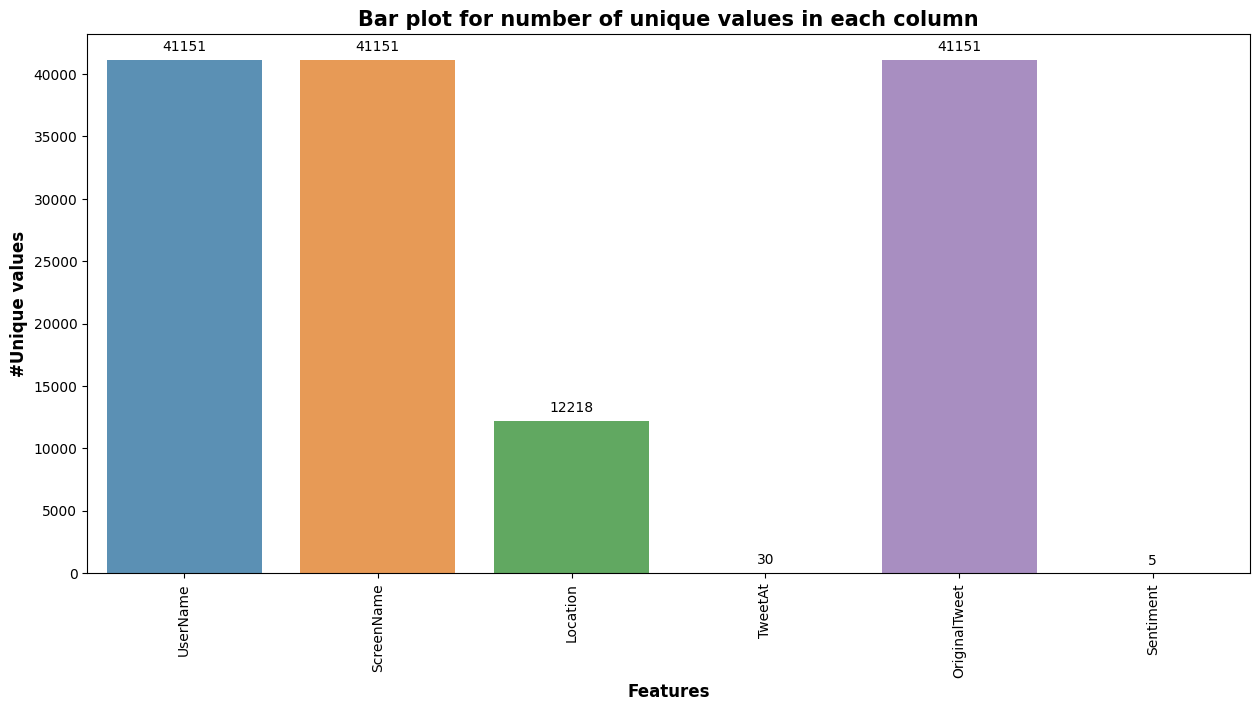

[Text(0, 0, 'London'),
 Text(1, 0, 'United States'),
 Text(2, 0, 'London, England'),
 Text(3, 0, 'New York, NY'),
 Text(4, 0, 'Washington, DC')]

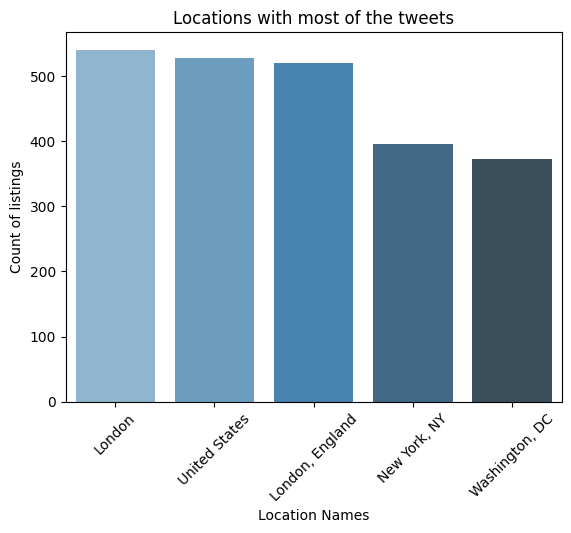

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import re
import pandas as pd
import plotly.graph_objects as go
from collections import Counter
pd.set_option("display.max_colwidth", 200)
import warnings
warnings.filterwarnings("ignore")
from string import punctuation
from nltk.corpus import stopwords
# print(stopwords.words('english')[10:15])

pd.set_option("display.max_colwidth", 200)
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('/content/drive/MyDrive/5344/Corona_NLP_train.csv',encoding = 'ISO-8859-1')
missing_values = pd.DataFrame()
missing_values['column'] = df.columns
missing_values['percent'] = [round(100 * df[col].isnull().sum() / len(df), 2) for col in df.columns]
missing_values = missing_values.sort_values('percent')
missing_values = missing_values[missing_values['percent'] > 0]

# Unique Value of each columns
unique_df = pd.DataFrame()
unique_df['Features'] = df.columns
unique = []
for i in df.columns:
    unique.append(df[i].nunique())
unique_df['Uniques'] = unique
f, ax = plt.subplots(1, 1, figsize=(15, 7))
splot = sns.barplot(x=unique_df['Features'], y=unique_df['Uniques'], alpha=0.8)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center',
                   va='center', xytext=(0, 9), textcoords='offset points')
plt.title('Bar plot for number of unique values in each column', weight='bold', size=15)
plt.ylabel('#Unique values', size=12, weight='bold')
plt.xlabel('Features', size=12, weight='bold')
plt.xticks(rotation=90)
plt.show()


# Plot Of Top 15 Locations Of Tweet
loc_analysis = pd.DataFrame(df['Location'].value_counts().sort_values(ascending=False))
loc_analysis = loc_analysis.rename(columns={'Location':'count'})
data = {
   "values": loc_analysis['count'][:15],
   "labels": loc_analysis.index[:15],
   "domain": {"column": 0},
   "name": "Location Name",
   "hoverinfo":"label+percent+name",
   "hole": .4,
   "type": "pie"
}
layout = go.Layout(title="<b>Ratio on Location</b>", legend=dict(x=1, y=1, orientation="h"))

data = [data]
fig = go.Figure(data = data, layout = layout)
fig.update_layout(title_x=0.5)
fig.show()

# Top 10 locations of tweet
Top_Location_Of_tweet= df['Location'].value_counts().head(5)
Top_Location_Of_tweet_df=pd.DataFrame(Top_Location_Of_tweet)
Top_Location_Of_tweet_df.reset_index(inplace=True)
Top_Location_Of_tweet_df.rename(columns={'index':'Location', 'Location':'Location_Count'}, inplace=True)


viz_1=sns.barplot(x="Location", y='Location_Count', data=Top_Location_Of_tweet_df,
                 palette='Blues_d')
viz_1.set_title('Locations with most of the tweets')
viz_1.set_ylabel('Count of listings')
viz_1.set_xlabel('Location Names')
viz_1.set_xticklabels(viz_1.get_xticklabels(), rotation=45)

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

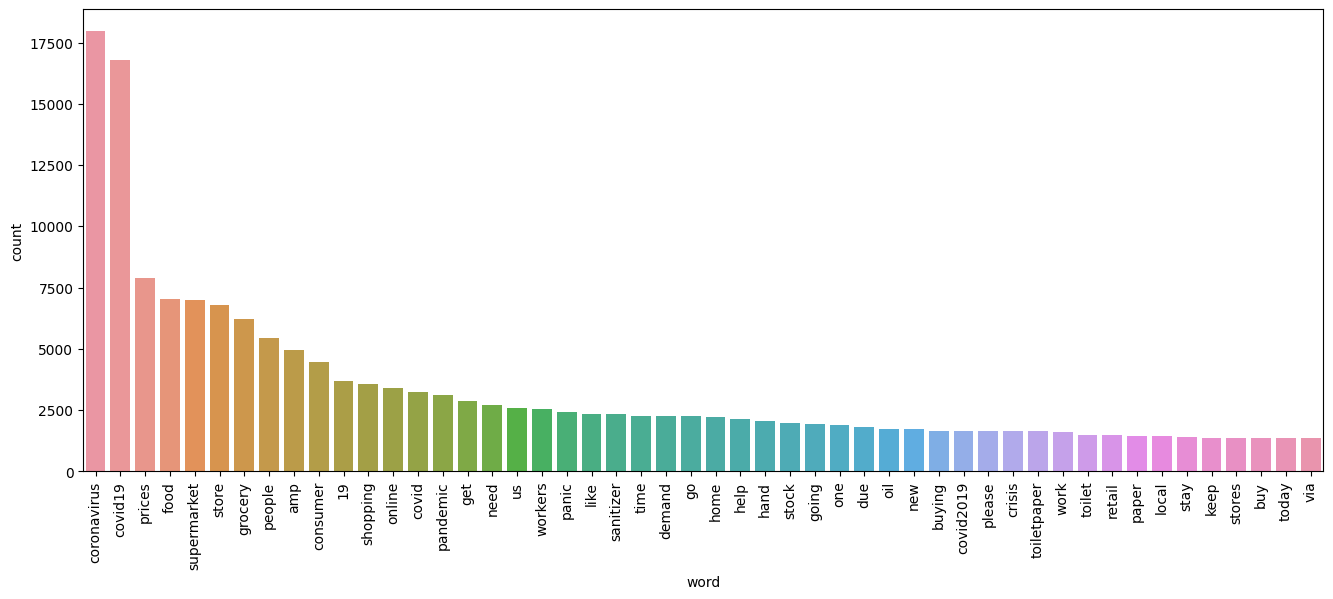

In [ ]:
from nltk.corpus import stopwords
def punctuation_stopwords_removal(sms):
    remove_punctuation = [ch for ch in sms if ch not in punctuation]
    # convert them back to sentences and split into words
    remove_punctuation = "".join(remove_punctuation).split()
    filtered_sms = [word.lower() for word in remove_punctuation if word.lower() not in stopwords.words('english')]
    return filtered_sms
def draw_bar_graph_for_text_visualization(df):
    tweets_from_loc = df
#     df.loc[df.Location==location]
    tweets_from_loc.loc[:, 'OriginalTweet'] = tweets_from_loc['OriginalTweet'].apply(punctuation_stopwords_removal)
    loc_tweets_curated = tweets_from_loc['OriginalTweet'].tolist()
    loc_tweet_list = []
    for sublist in loc_tweets_curated:
        for word in sublist:
            loc_tweet_list.append(word)
    loc_tweet_count = Counter(loc_tweet_list)
    loc_top_30_words = pd.DataFrame(loc_tweet_count.most_common(50), columns=['word', 'count'])
    fig, ax = plt.subplots(figsize=(16, 6))
    sns.barplot(x='word', y='count',
                data=loc_top_30_words, ax=ax)
#     plt.title("Top 50 Prevelant Words in {}".format(location))
    plt.xticks(rotation='vertical');

draw_bar_graph_for_text_visualization(df)

<Axes: xlabel='Sentiment', ylabel='count'>

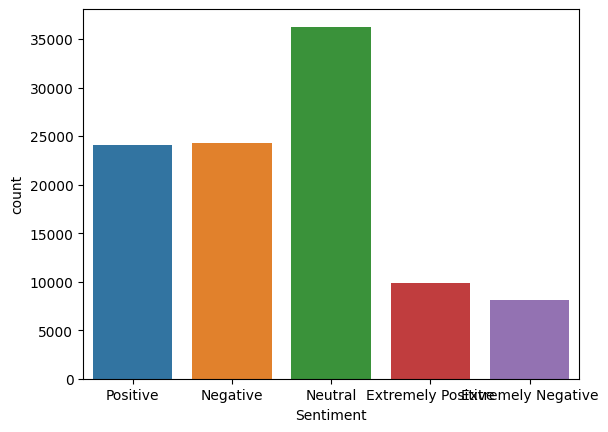

In [ ]:
sns.countplot(x=df_output_sentiment['Sentiment'])

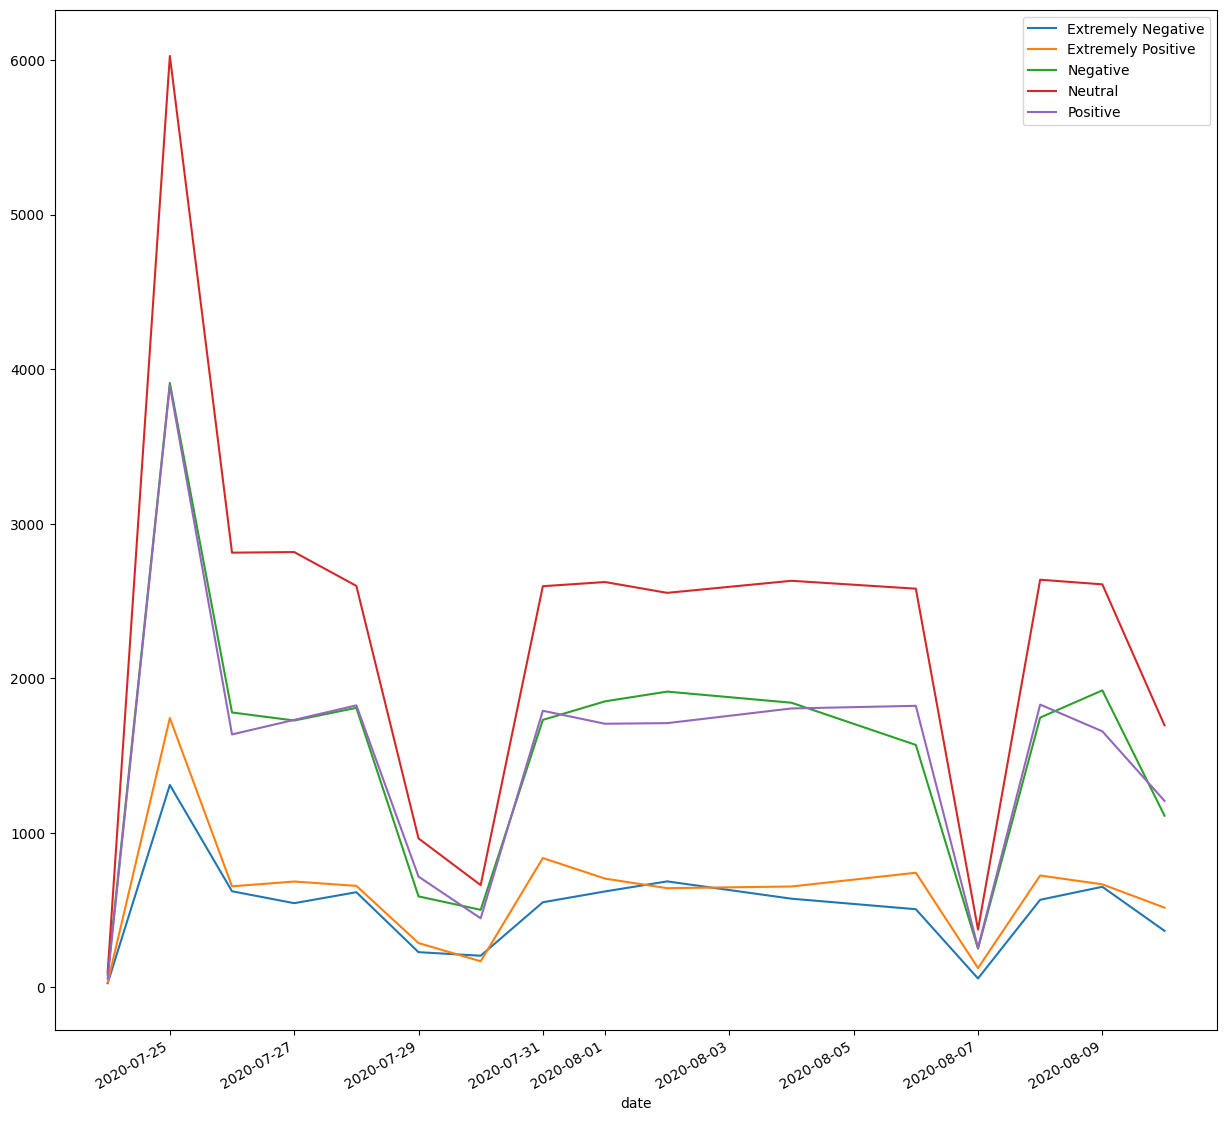

In [ ]:
df_plot = (df_output_sentiment.reset_index().groupby(['date', 'Sentiment'], as_index=False).count().rename(columns={'index': 'count'}))
fig, ax = plt.subplots()
for key, data in df_plot.groupby('Sentiment'):
    data.plot(x='date', y='count', ax=ax, label=key, figsize=(15, 15))